In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tikzplotlib as tikz
from scipy import stats
from scipy.stats import ks_2samp

plt.rcParams['figure.figsize'] = [10,7]
random.seed(0)

In [ ]:
# The function returns the unique element of a list.
def unique(list1): 
    x = np.array(list1) 
    x = (np.unique(x))
    return x.tolist()

# From the file containing the edges list, the function imports the list of edges and finds the set of nodes.
def import_nodes(filename):
    edges = pd.read_csv(filename)
    nodes = edges['Source'].to_list()
    nodes = [nodes, edges['Target'].to_list()]
    nodes = unique(nodes)
    return nodes, edges

# From the list of edges and nodes, the function creates a dataframe in which, each row is associated with a node.
# The row contains the node id, its in-degree, and its ranking (based on the in-degree).
# Rows are ordered in decreasing in-degree, and increasing ranking.

def create_nodes_df(nodes, edges):
    indegree = [0]*len(nodes)
    outdegree = [0]*len(nodes)
    data = {'id':nodes, 'indegree':   indegree, 'outdegree': outdegree}
    nodes_df = pd.DataFrame(data)
    edges_list = edges.values.tolist()
    for edge in edges_list:
        nodes_df.loc[nodes_df['id']==edge[1], 'indegree'] += 1
        nodes_df.loc[nodes_df['id']==edge[0], 'outdegree'] += 1
    nodes_df.sort_values(by=['indegree'], inplace=True, ascending=False)
    
    rank_array = np.linspace(1, len(nodes), len(nodes), dtype=int)
    rank_list = rank_array.tolist()
    nodes_df['rank']=rank_list
    
    return nodes_df

In [ ]:
[nodes, edges] = import_nodes('/content/gdrive/MyDrive/SNA/graph.csv') 
nodes_df = create_nodes_df(nodes, edges)

In [ ]:
nodes_df.head(5)

,id,indegree,outdegree,rank
1175,56341402,3022,125,1
3208,579299426,2970,183,2
3214,582161546,2477,336,3
1457,90258002,2217,191,4
2167,229910053,1922,533,5


Using the edge list, we create a data-frame (friends_df) in which, for each user id, we store the rank of the userid's followee, sequentially ordered (the first one is the oldest followee).

In [ ]:
friends_df = pd.DataFrame(columns=['id', 'friends'])
node = edges['Source'][0]
friends = []
for index, edge in edges.iterrows():
    if (node != edge['Source']):
        friends_df = friends_df.append({'id' : node , 'friends' : friends}, ignore_index=True)
        node = edge['Source']
        friends = []
    friend_rank = nodes_df.loc[nodes_df['id']==edge['Target']]
    friends.append(friend_rank['rank'].values[0]) 

In [ ]:
friends_df.head(5)

,id,friends
0,1070010671918665728,"[17, 66, 236, 927, 29, 950, 14, 25, 377, 241, ..."
1,848539500167004160,"[124, 785, 830, 1797, 2040, 1295, 233, 414, 69..."
2,814015332,"[2696, 1303, 1140, 773, 1869, 1851, 3255, 661,..."
3,1220359214884904965,"[4909, 3143, 5104, 947, 1219, 3880, 2632, 79, ..."
4,382393,"[3716, 2652, 1620, 305, 4051, 1294, 634, 3979,..."


In [ ]:
len(friends)

34

# Computing violation with respect to the median
The following code computes, for each node (with at least two followees), the probability p_i , and it stores it in the vector p.To do so, it uses the list of followers, ordered in temporal sequence, as given by the Twitter API.
Similarly, it computes the same probability under the null hypothesis, i.e., after reshuffling the list of followers (thus, removing any temporal pattern).

Data.
Size: 6474
Mean: 0.44942986776465543
Median: 0.43548387096774194
Std-dev: 0.18891446024303749

0-hypotesis:
Mean: 0.48897498809057566
Median: 0.5
Std-dev: 0.1737990355550674

Kolmogorov-Smirnov tests, two samples


Ks_2sampResult(statistic=0.2147239263803681, pvalue=2.785253346971273e-135)

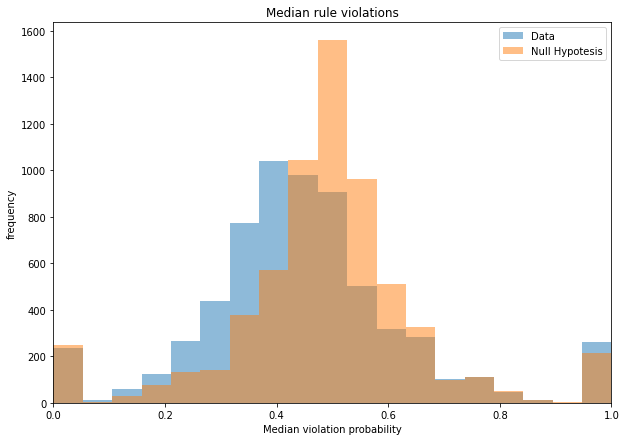

In [ ]:
random.seed(0)
p = []
p_null_hypothesis = []
for node in friends_df['id']:
    friends = (friends_df.loc[friends_df['id'] == node, 'friends'].values[0]).copy()
    friends_null_hypothesis = random.sample(friends, len(friends))
    t = np.linspace(1, len(friends), len(friends), dtype=int)
    series  = {'time': t, 'friends': friends}
    violations = np.NaN
    violations_null_hypothesis = np.NaN
    median = []
    median.append(friends[0])
    median_null_hypothesis = []
    median_null_hypothesis.append(friends_null_hypothesis[0])
    if (len(friends)>1):
        violations = 0
        violations_null_hypothesis = 0
    for i in range(1, len(friends)):
        if (friends[i]>median[-1]):
            violations+=1
        if (friends_null_hypothesis[i]>median_null_hypothesis[-1]):
            violations_null_hypothesis+=1
        median.append(np.median(friends[0:i+1]))
        median_null_hypothesis.append(np.median(friends_null_hypothesis[0:i+1]))
    if (len(friends)>1):
        p.append(violations/(len(friends)-1))
        p_null_hypothesis.append(violations_null_hypothesis/(len(friends)-1))
    else:
        p.append(np.NaN)
        p_null_hypothesis.append(np.NaN)
plt.hist(p, bins=19, alpha=0.5, label='Data')
plt.hist(p_null_hypothesis, bins=19, alpha = 0.5, label='Null Hypotesis')
plt.xlim((0,1))
plt.xlabel('Median violation probability')
plt.ylabel('frequency')
plt.title('Median rule violations')
plt.legend(loc="upper right")
tikz.save("median_violation_histogram.tikz")
print('Data.')
print('Size:', np.count_nonzero(~np.isnan(p)))
print('Mean:', np.nanmean(p))
print('Median:', np.nanmedian(p))
print('Std-dev:', np.nanstd(p))
print('')
print('0-hypotesis:')
print('Mean:', np.nanmean(p_null_hypothesis))
print('Median:', np.nanmedian(p_null_hypothesis))
print('Std-dev:', np.nanstd(p_null_hypothesis))
print('')
print('Kolmogorov-Smirnov tests, two samples')
ks_2samp(p, p_null_hypothesis)